# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    data_transform = transforms.Compose([transforms.Resize(image_size),
                                         transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(data_dir,transform=data_transform)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=0, shuffle=True)
    
    return train_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

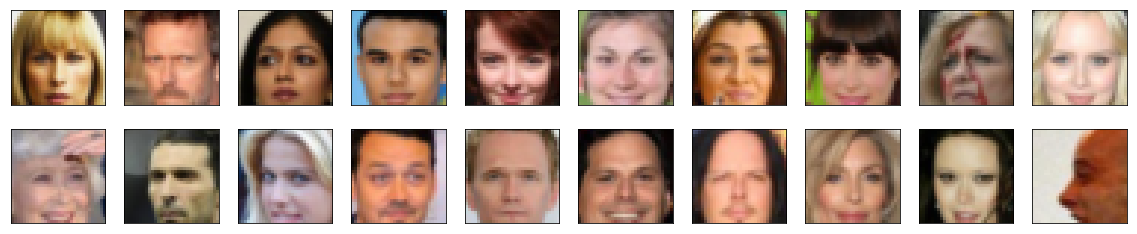

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9294)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict 

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        kernel_size = 4
        stride = 2
        padding = 1
        
        self.features = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(3, conv_dim,kernel_size,stride,padding,bias=False)),
            ('lrelu1',nn.LeakyReLU(negative_slope=0.2,inplace=True)),
            ('conv2',nn.Conv2d(conv_dim, conv_dim*2,kernel_size,stride,padding,bias=False)),
            ('bn2',nn.BatchNorm2d(conv_dim*2)),
            ('lrelu2',nn.LeakyReLU(negative_slope=0.2,inplace=True)),
            ('conv3',nn.Conv2d(conv_dim*2, conv_dim*4,kernel_size,stride,padding,bias=False)),
            ('bn3',nn.BatchNorm2d(conv_dim*4)),
            ('lrelu3',nn.LeakyReLU(negative_slope=0.2,inplace=True))
        ]))
        
        self.classifier = nn.Linear(conv_dim*4*4*4,1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = self.features(x)
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        # final output layer
        out = self.classifier(out)
        return out

print(Discriminator(32))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Discriminator(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (lrelu1): LeakyReLU(negative_slope=0.2, inplace)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu2): LeakyReLU(negative_slope=0.2, inplace)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu3): LeakyReLU(negative_slope=0.2, inplace)
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)
Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        kernel_size = 4
        stride = 2
        padding = 1
        
        self.generator = nn.Sequential(OrderedDict([
            ('t_conv1',nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size,
                                          stride, padding, bias=False)),
            ('bn1',nn.BatchNorm2d(conv_dim*2)),
            ('relu1',nn.ReLU(True)),
            ('t_conv2',nn.ConvTranspose2d(conv_dim*2, conv_dim, kernel_size,
                                          stride, padding, bias=False)),
            ('bn2',nn.BatchNorm2d(conv_dim)),
            ('relu2',nn.ReLU(True)),
            ('t_conv3',nn.ConvTranspose2d(conv_dim, 3, kernel_size,
                                          stride, padding, bias=False)),
            ('tanh3', nn.Tanh())
        ]))
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        
        out = self.fc(x)
        
        # reshape
        out = out.view(-1, self.conv_dim*4, 4, 4)# (batch_size, depth, 4, 4)
        
        out = self.generator(out)
        
        return out

print(Generator(100,32))
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (generator): Sequential(
    (t_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (t_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (t_conv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (tanh3): Tanh()
  )
)
Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
                
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)   

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (features): Sequential(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (lrelu1): LeakyReLU(negative_slope=0.2, inplace)
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu2): LeakyReLU(negative_slope=0.2, inplace)
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu3): LeakyReLU(negative_slope=0.2, inplace)
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (generator): Sequential(
    (t_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [16]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss 

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [17]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [18]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()          
            
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [19]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.3686 | g_loss: 0.9735
Epoch [    1/  100] | d_loss: 0.1128 | g_loss: 3.8255
Epoch [    1/  100] | d_loss: 0.3550 | g_loss: 2.3603
Epoch [    1/  100] | d_loss: 1.6028 | g_loss: 7.0377
Epoch [    1/  100] | d_loss: 0.4912 | g_loss: 2.4451
Epoch [    1/  100] | d_loss: 0.6364 | g_loss: 1.1028
Epoch [    1/  100] | d_loss: 0.6721 | g_loss: 2.3253
Epoch [    1/  100] | d_loss: 1.0965 | g_loss: 3.1569
Epoch [    1/  100] | d_loss: 0.6309 | g_loss: 1.7024
Epoch [    1/  100] | d_loss: 0.7914 | g_loss: 1.5569
Epoch [    1/  100] | d_loss: 0.8780 | g_loss: 1.0043
Epoch [    1/  100] | d_loss: 0.8601 | g_loss: 1.3269
Epoch [    1/  100] | d_loss: 0.9843 | g_loss: 1.6681
Epoch [    1/  100] | d_loss: 0.9701 | g_loss: 1.5307
Epoch [    1/  100] | d_loss: 0.8540 | g_loss: 1.3369
Epoch [    2/  100] | d_loss: 1.0049 | g_loss: 1.1949
Epoch [    2/  100] | d_loss: 1.1358 | g_loss: 2.4374
Epoch [    2/  100] | d_loss: 0.9439 | g_loss: 1.3131
Epoch [    2/  100] | d_loss

Epoch [   11/  100] | d_loss: 1.4210 | g_loss: 0.7503
Epoch [   11/  100] | d_loss: 0.9276 | g_loss: 1.4595
Epoch [   11/  100] | d_loss: 0.9468 | g_loss: 1.8663
Epoch [   11/  100] | d_loss: 0.8187 | g_loss: 1.4341
Epoch [   11/  100] | d_loss: 0.7307 | g_loss: 1.0539
Epoch [   11/  100] | d_loss: 0.9946 | g_loss: 1.8959
Epoch [   11/  100] | d_loss: 0.7736 | g_loss: 1.4686
Epoch [   11/  100] | d_loss: 0.7714 | g_loss: 1.2026
Epoch [   11/  100] | d_loss: 0.7925 | g_loss: 1.0195
Epoch [   11/  100] | d_loss: 0.7973 | g_loss: 1.4428
Epoch [   11/  100] | d_loss: 0.7212 | g_loss: 1.7616
Epoch [   11/  100] | d_loss: 0.6691 | g_loss: 1.5564
Epoch [   11/  100] | d_loss: 0.8856 | g_loss: 2.0820
Epoch [   12/  100] | d_loss: 0.9882 | g_loss: 1.4698
Epoch [   12/  100] | d_loss: 0.8751 | g_loss: 1.6142
Epoch [   12/  100] | d_loss: 0.9988 | g_loss: 0.7820
Epoch [   12/  100] | d_loss: 0.6816 | g_loss: 2.0430
Epoch [   12/  100] | d_loss: 0.7588 | g_loss: 1.3819
Epoch [   12/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.5940 | g_loss: 2.0088
Epoch [   21/  100] | d_loss: 0.4033 | g_loss: 2.5608
Epoch [   21/  100] | d_loss: 0.4343 | g_loss: 2.4478
Epoch [   21/  100] | d_loss: 0.5128 | g_loss: 1.7794
Epoch [   21/  100] | d_loss: 0.5135 | g_loss: 2.3005
Epoch [   21/  100] | d_loss: 0.6596 | g_loss: 1.8698
Epoch [   21/  100] | d_loss: 0.4290 | g_loss: 2.0803
Epoch [   21/  100] | d_loss: 0.5984 | g_loss: 1.4984
Epoch [   21/  100] | d_loss: 0.4919 | g_loss: 2.4372
Epoch [   21/  100] | d_loss: 0.4756 | g_loss: 2.5749
Epoch [   21/  100] | d_loss: 0.3847 | g_loss: 2.1458
Epoch [   22/  100] | d_loss: 0.6656 | g_loss: 2.7066
Epoch [   22/  100] | d_loss: 0.4326 | g_loss: 2.3150
Epoch [   22/  100] | d_loss: 0.7134 | g_loss: 1.1841
Epoch [   22/  100] | d_loss: 0.7570 | g_loss: 3.7678
Epoch [   22/  100] | d_loss: 0.5364 | g_loss: 1.3656
Epoch [   22/  100] | d_loss: 0.4408 | g_loss: 1.7404
Epoch [   22/  100] | d_loss: 0.5316 | g_loss: 1.8754
Epoch [   22/  100] | d_loss

Epoch [   31/  100] | d_loss: 2.0506 | g_loss: 0.5947
Epoch [   31/  100] | d_loss: 0.3552 | g_loss: 2.2794
Epoch [   31/  100] | d_loss: 0.4751 | g_loss: 3.1648
Epoch [   31/  100] | d_loss: 0.3306 | g_loss: 2.2455
Epoch [   31/  100] | d_loss: 0.2629 | g_loss: 1.6251
Epoch [   31/  100] | d_loss: 0.2837 | g_loss: 2.4845
Epoch [   31/  100] | d_loss: 0.2408 | g_loss: 2.6312
Epoch [   31/  100] | d_loss: 0.4061 | g_loss: 2.1096
Epoch [   31/  100] | d_loss: 2.1380 | g_loss: 0.6010
Epoch [   32/  100] | d_loss: 2.4082 | g_loss: 2.0708
Epoch [   32/  100] | d_loss: 0.4285 | g_loss: 1.6892
Epoch [   32/  100] | d_loss: 0.3989 | g_loss: 2.6616
Epoch [   32/  100] | d_loss: 0.2289 | g_loss: 3.5003
Epoch [   32/  100] | d_loss: 0.2655 | g_loss: 2.3703
Epoch [   32/  100] | d_loss: 0.3434 | g_loss: 2.9684
Epoch [   32/  100] | d_loss: 0.3401 | g_loss: 2.4227
Epoch [   32/  100] | d_loss: 0.4239 | g_loss: 2.0685
Epoch [   32/  100] | d_loss: 0.3579 | g_loss: 2.3230
Epoch [   32/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.7789 | g_loss: 3.3063
Epoch [   41/  100] | d_loss: 0.3321 | g_loss: 3.0802
Epoch [   41/  100] | d_loss: 0.2656 | g_loss: 1.9713
Epoch [   41/  100] | d_loss: 0.2422 | g_loss: 2.8571
Epoch [   41/  100] | d_loss: 0.3773 | g_loss: 4.1744
Epoch [   41/  100] | d_loss: 0.2110 | g_loss: 3.7168
Epoch [   41/  100] | d_loss: 0.1664 | g_loss: 4.0658
Epoch [   42/  100] | d_loss: 0.1489 | g_loss: 4.0244
Epoch [   42/  100] | d_loss: 0.2704 | g_loss: 3.8231
Epoch [   42/  100] | d_loss: 0.1936 | g_loss: 3.5349
Epoch [   42/  100] | d_loss: 0.3090 | g_loss: 4.2035
Epoch [   42/  100] | d_loss: 0.1885 | g_loss: 3.4000
Epoch [   42/  100] | d_loss: 0.1432 | g_loss: 2.9036
Epoch [   42/  100] | d_loss: 1.3410 | g_loss: 0.9332
Epoch [   42/  100] | d_loss: 0.4584 | g_loss: 1.6881
Epoch [   42/  100] | d_loss: 0.5961 | g_loss: 3.7295
Epoch [   42/  100] | d_loss: 0.3662 | g_loss: 3.9926
Epoch [   42/  100] | d_loss: 0.1914 | g_loss: 3.0168
Epoch [   42/  100] | d_loss

Epoch [   51/  100] | d_loss: 0.1315 | g_loss: 4.0937
Epoch [   51/  100] | d_loss: 0.1696 | g_loss: 2.4269
Epoch [   51/  100] | d_loss: 0.4649 | g_loss: 1.9998
Epoch [   51/  100] | d_loss: 0.1234 | g_loss: 4.1113
Epoch [   51/  100] | d_loss: 0.2243 | g_loss: 3.5898
Epoch [   52/  100] | d_loss: 0.1487 | g_loss: 4.2028
Epoch [   52/  100] | d_loss: 0.1221 | g_loss: 3.1200
Epoch [   52/  100] | d_loss: 1.5141 | g_loss: 0.1167
Epoch [   52/  100] | d_loss: 0.1248 | g_loss: 3.9919
Epoch [   52/  100] | d_loss: 0.1975 | g_loss: 2.4366
Epoch [   52/  100] | d_loss: 0.4807 | g_loss: 2.5657
Epoch [   52/  100] | d_loss: 1.4411 | g_loss: 0.3168
Epoch [   52/  100] | d_loss: 0.1964 | g_loss: 2.7753
Epoch [   52/  100] | d_loss: 0.2046 | g_loss: 3.0842
Epoch [   52/  100] | d_loss: 0.1368 | g_loss: 3.0222
Epoch [   52/  100] | d_loss: 0.2773 | g_loss: 2.3329
Epoch [   52/  100] | d_loss: 0.2224 | g_loss: 4.2743
Epoch [   52/  100] | d_loss: 0.1626 | g_loss: 3.2416
Epoch [   52/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.8939 | g_loss: 1.1943
Epoch [   61/  100] | d_loss: 1.2380 | g_loss: 3.8694
Epoch [   61/  100] | d_loss: 0.1367 | g_loss: 4.0894
Epoch [   62/  100] | d_loss: 0.2706 | g_loss: 4.3468
Epoch [   62/  100] | d_loss: 0.1654 | g_loss: 2.8685
Epoch [   62/  100] | d_loss: 0.1253 | g_loss: 3.5433
Epoch [   62/  100] | d_loss: 0.1115 | g_loss: 3.4269
Epoch [   62/  100] | d_loss: 0.0956 | g_loss: 4.3597
Epoch [   62/  100] | d_loss: 0.0727 | g_loss: 4.1106
Epoch [   62/  100] | d_loss: 0.1941 | g_loss: 2.9348
Epoch [   62/  100] | d_loss: 0.2133 | g_loss: 4.0159
Epoch [   62/  100] | d_loss: 0.5190 | g_loss: 1.1527
Epoch [   62/  100] | d_loss: 0.4031 | g_loss: 2.1352
Epoch [   62/  100] | d_loss: 0.1169 | g_loss: 4.2900
Epoch [   62/  100] | d_loss: 0.1750 | g_loss: 3.0613
Epoch [   62/  100] | d_loss: 0.2787 | g_loss: 4.2333
Epoch [   62/  100] | d_loss: 0.2203 | g_loss: 4.4078
Epoch [   62/  100] | d_loss: 0.3105 | g_loss: 4.4696
Epoch [   63/  100] | d_loss

Epoch [   71/  100] | d_loss: 0.1581 | g_loss: 4.5828
Epoch [   72/  100] | d_loss: 0.1886 | g_loss: 4.8034
Epoch [   72/  100] | d_loss: 0.1123 | g_loss: 4.4853
Epoch [   72/  100] | d_loss: 0.2150 | g_loss: 5.6320
Epoch [   72/  100] | d_loss: 0.0811 | g_loss: 4.3923
Epoch [   72/  100] | d_loss: 0.0795 | g_loss: 3.6204
Epoch [   72/  100] | d_loss: 0.0994 | g_loss: 4.0449
Epoch [   72/  100] | d_loss: 0.0716 | g_loss: 4.1183
Epoch [   72/  100] | d_loss: 0.0910 | g_loss: 4.9032
Epoch [   72/  100] | d_loss: 0.0579 | g_loss: 3.7005
Epoch [   72/  100] | d_loss: 0.1532 | g_loss: 4.3177
Epoch [   72/  100] | d_loss: 0.0717 | g_loss: 4.4792
Epoch [   72/  100] | d_loss: 0.0724 | g_loss: 4.0423
Epoch [   72/  100] | d_loss: 0.1464 | g_loss: 5.7935
Epoch [   72/  100] | d_loss: 1.6617 | g_loss: 1.9301
Epoch [   72/  100] | d_loss: 0.4210 | g_loss: 3.7857
Epoch [   73/  100] | d_loss: 0.3931 | g_loss: 1.9261
Epoch [   73/  100] | d_loss: 0.2861 | g_loss: 3.9032
Epoch [   73/  100] | d_loss

Epoch [   82/  100] | d_loss: 0.0487 | g_loss: 5.4259
Epoch [   82/  100] | d_loss: 0.0656 | g_loss: 4.8743
Epoch [   82/  100] | d_loss: 0.0639 | g_loss: 5.4330
Epoch [   82/  100] | d_loss: 0.0949 | g_loss: 4.4719
Epoch [   82/  100] | d_loss: 0.1203 | g_loss: 3.5929
Epoch [   82/  100] | d_loss: 0.0743 | g_loss: 4.4679
Epoch [   82/  100] | d_loss: 0.0431 | g_loss: 4.7809
Epoch [   82/  100] | d_loss: 0.8645 | g_loss: 2.9895
Epoch [   82/  100] | d_loss: 0.5916 | g_loss: 2.0168
Epoch [   82/  100] | d_loss: 0.2195 | g_loss: 3.0110
Epoch [   82/  100] | d_loss: 0.6114 | g_loss: 1.8695
Epoch [   82/  100] | d_loss: 0.1473 | g_loss: 4.0104
Epoch [   82/  100] | d_loss: 0.1177 | g_loss: 3.7771
Epoch [   82/  100] | d_loss: 0.1990 | g_loss: 3.8010
Epoch [   83/  100] | d_loss: 0.0648 | g_loss: 4.2511
Epoch [   83/  100] | d_loss: 0.0812 | g_loss: 4.3058
Epoch [   83/  100] | d_loss: 0.0933 | g_loss: 3.6929
Epoch [   83/  100] | d_loss: 0.1510 | g_loss: 3.0768
Epoch [   83/  100] | d_loss

Epoch [   92/  100] | d_loss: 0.0912 | g_loss: 4.9212
Epoch [   92/  100] | d_loss: 4.6856 | g_loss: 4.0278
Epoch [   92/  100] | d_loss: 0.1096 | g_loss: 5.0667
Epoch [   92/  100] | d_loss: 0.0961 | g_loss: 4.5954
Epoch [   92/  100] | d_loss: 0.1003 | g_loss: 4.3117
Epoch [   92/  100] | d_loss: 0.0855 | g_loss: 4.2674
Epoch [   92/  100] | d_loss: 0.0526 | g_loss: 5.2280
Epoch [   92/  100] | d_loss: 0.0802 | g_loss: 4.4260
Epoch [   92/  100] | d_loss: 0.5580 | g_loss: 1.7820
Epoch [   92/  100] | d_loss: 0.0651 | g_loss: 3.9724
Epoch [   92/  100] | d_loss: 0.0512 | g_loss: 4.0793
Epoch [   92/  100] | d_loss: 0.1040 | g_loss: 5.1901
Epoch [   93/  100] | d_loss: 0.0636 | g_loss: 4.8286
Epoch [   93/  100] | d_loss: 0.0640 | g_loss: 3.6803
Epoch [   93/  100] | d_loss: 0.0411 | g_loss: 4.0805
Epoch [   93/  100] | d_loss: 0.0357 | g_loss: 6.5586
Epoch [   93/  100] | d_loss: 0.1137 | g_loss: 3.1050
Epoch [   93/  100] | d_loss: 0.0601 | g_loss: 5.1361
Epoch [   93/  100] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

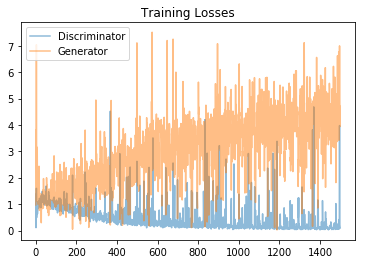

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

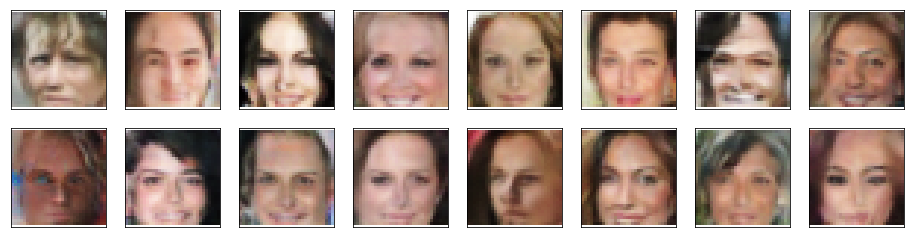

In [23]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

---
# Experimentation

In [1]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict 

%matplotlib inline

In [2]:
# Parameters

# Define function hyperparameters
batch_size = 128
img_size = 64

# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# set number of epochs 
n_epochs = 10

## Create a DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    data_transform = transforms.Compose([transforms.Resize(image_size),
                                         transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(data_dir,transform=data_transform)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=0, shuffle=True)
    
    return train_loader

In [4]:
# Call your function and get a dataloader
batch_size = 10
img_size = 64
celeba_train_loader_test = get_dataloader(batch_size, img_size)

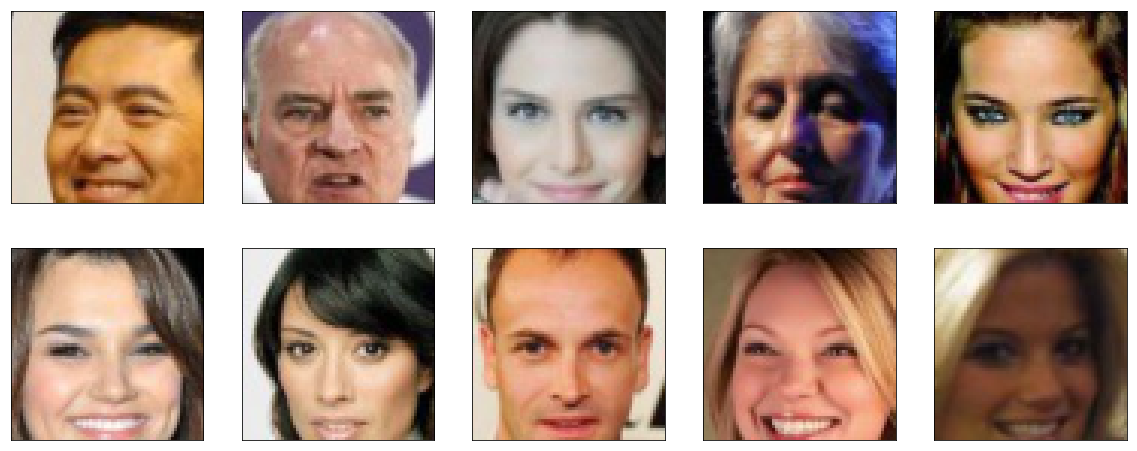

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 8))
plot_size=10
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [6]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    return x

# Define the Model

## Discriminator

In [7]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        kernel_size = 4
        stride = 2
        padding = 1
        
        self.discriminator = nn.Sequential(OrderedDict([
            ('conv1',nn.Conv2d(3, conv_dim,kernel_size,stride,padding,bias=False)),
            ('lrelu1',nn.LeakyReLU(negative_slope=0.2,inplace=True)),
            ('conv2',nn.Conv2d(conv_dim, conv_dim*2,kernel_size,stride,padding,bias=False)),
            ('bn2',nn.BatchNorm2d(conv_dim*2)),
            ('lrelu2',nn.LeakyReLU(negative_slope=0.2,inplace=True)),
            ('conv3',nn.Conv2d(conv_dim*2, conv_dim*4,kernel_size,stride,padding,bias=False)),
            ('bn3',nn.BatchNorm2d(conv_dim*4)),
            ('lrelu3',nn.LeakyReLU(negative_slope=0.2,inplace=True)),
            ('conv4',nn.Conv2d(conv_dim*4, conv_dim*8,kernel_size,stride,padding,bias=False)),
            ('bn4',nn.BatchNorm2d(conv_dim*8)),
            ('lrelu4',nn.LeakyReLU(negative_slope=0.2,inplace=True)),
            ('conv5',nn.Conv2d(conv_dim*8,1,4,1,0,bias=False))
        ]))
            

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        out = self.discriminator(x)
        return out

print(Discriminator(64))

Discriminator(
  (discriminator): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (lrelu1): LeakyReLU(negative_slope=0.2, inplace)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu2): LeakyReLU(negative_slope=0.2, inplace)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu3): LeakyReLU(negative_slope=0.2, inplace)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu4): LeakyReLU(negative_slope=0.2, inplace)
    (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


## Generator

In [24]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        kernel_size = 4
        stride = 2
        padding = 1
                
        self.generator = nn.Sequential(OrderedDict([
            ('t_conv1',nn.ConvTranspose2d(z_size, conv_dim*8, kernel_size, 1, 0, bias=False)),
            ('bn1',nn.BatchNorm2d(conv_dim*8)),
            ('relu1',nn.ReLU(True)),
            ('t_conv2',nn.ConvTranspose2d(conv_dim*8, conv_dim*4, kernel_size,
                                          stride, padding, bias=False)),
            ('bn2',nn.BatchNorm2d(conv_dim*4)),
            ('relu2',nn.ReLU(True)),
            ('t_conv3',nn.ConvTranspose2d(conv_dim*4, conv_dim*2, kernel_size,
                                          stride, padding, bias=False)),
            ('bn3',nn.BatchNorm2d(conv_dim*2)),
            ('relu3',nn.ReLU(True)),
            ('t_conv4',nn.ConvTranspose2d(conv_dim*2, conv_dim, kernel_size,
                                          stride, padding, bias=False)),
            ('bn4',nn.BatchNorm2d(conv_dim)),
            ('relu4',nn.ReLU(True)),
            ('t_conv5',nn.ConvTranspose2d(conv_dim, 3, kernel_size,
                                          stride, padding, bias=False)),
            ('tanh5', nn.Tanh())
        ]))
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """        
        out = self.generator(x)
        
        return out

print(Generator(100,64))

test
Generator(
  (generator): Sequential(
    (t_conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (t_conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (t_conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (t_conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace)
    (t_conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1

## Init weights

In [25]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
        
        if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
                
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)   

## Build network

In [26]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [27]:
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

test
Discriminator(
  (discriminator): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (lrelu1): LeakyReLU(negative_slope=0.2, inplace)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu2): LeakyReLU(negative_slope=0.2, inplace)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu3): LeakyReLU(negative_slope=0.2, inplace)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu4): LeakyReLU(negative_slope=0.2, inplace)
    (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(


## Training on GPU

In [28]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


## Discriminator and Generator Losses

In [29]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss 

## Optimizers

In [30]:
import torch.optim as optim

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [45]:
def train(D, G, n_epochs,d_optimizer, g_optimizer, batch_size, z_size=100, img_size=64 ,save_samples=True):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Call your function and get a dataloader
    celeba_train_loader = get_dataloader(batch_size, img_size)
    
    # used for print_msg 
    epoch_len = len(str(n_epochs))
    batches = len(celeba_train_loader)
    batches_len = len(str(batches))
    # print 10 times per epoch
    print_every = batches // 10
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    avg_losses = []
    d_losses = []
    g_losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 64
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size, 1, 1))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(1, n_epochs + 1):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            _batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()          
            
            # 1. Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(_batch_size, z_size, 1, 1))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(_batch_size, z_size, 1, 1))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # Add first loss before training starts
            if batch_i == 0 and epoch == 1:
                losses.append((d_loss.item(), g_loss.item()))
            
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # record loss
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # calculate average loss
                d_loss_avg = np.average(d_losses)
                g_loss_avg = np.average(g_losses)
                # print discriminator and generator loss
                print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}]' +
                             f'[{batch_i+1:>{batches_len}}/{batches:>{batches_len}}] | ' +
                             f'd_loss: {d_loss_avg:.5f} | ' +
                             f'g_loss: {g_loss_avg:.5f}')
                print(print_msg)
                
        ## AFTER EACH EPOCH##
        
        # calculate average loss over an epoch
        d_loss_avg = np.average(d_losses)
        g_loss_avg = np.average(g_losses)
        losses.append((d_loss_avg, g_loss_avg))     
        
        if save_samples:
            # generate and save sample, fake images
            G.eval() # for generating samples
            samples_z = G(fixed_z)
            samples.append(samples_z)
            G.train() # back to training mode
        
        # reset, only track loss per epoch fro average
        d_losses = []
        g_losses = []
    
    
    if save_samples:
        _lr = d_optimizer.param_groups[0]['lr']
        _beta1 = g_optimizer.param_groups[0]['betas'][0]
        # Save training generator samples
        with open(f'training_samples/train_samples_lr_{_lr:.4f}_beta1_{_beta1:.2f}_bs_{batch_size}.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    # finally return losses
    _lr = d_optimizer.param_groups[0]['lr']
    _beta1 = g_optimizer.param_groups[0]['betas'][0]
    title = f'lr_{_lr:.4f}_beta1_{_beta1:.2f}_bs_{batch_size}'
    
    return title, losses

### Hyperparameter optimization

Before training our final model we are going to search do random hyper-prarmeter search, which is the [recommended way to search for parameters](http://cs231n.github.io/neural-networks-3/). The two parameters we are gonna search through is beta1 and the learning rate since this are the two that needs tuning as shown in [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf). For beta1 we are searching in ```10**np.random.uniform(0,-1)``` $[0,0.1]$, and for the learning rate ```10**np.random.uniform(-3,-4)``` $[0.001,0.0001]$. The best parameters for the mentioned paper was lr = 0.0002 and beta1=0.5, so the range we chose the range closes to these values. 

In [46]:
d_conv_dim = 64
g_conv_dim = 64
z_s = 100

beta2 = 0.999 # default value
batch_s = 32

# set number of epochs 
n_epochs = 1

runs = 20
for run in range(runs):
    D, G = build_network(d_conv_dim, g_conv_dim, z_s)
    lr = 10**np.random.uniform(-3,-4)
    beta1 = 10**np.random.uniform(0,-1)
    print(f'Run {run+1} of {runs}: lr {lr:.5f}, beta1 {beta1:.5f}, bs {batch_s}')
    # Create optimizers for the discriminator and generator
    d_opt = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_opt = optim.Adam(G.parameters(), lr, [beta1, beta2])
    title, loss = train(D, G, n_epochs, d_opt, g_opt, batch_s,z_size=z_s ,img_size=img_s, save_samples=False)

KeyboardInterrupt: 

## Training loss

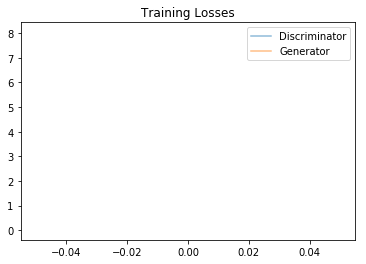

In [45]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [47]:
# Load samples from generator, taken while training
with open('train_samples_2.pkl', 'rb') as f:
    samples = pkl.load(f)

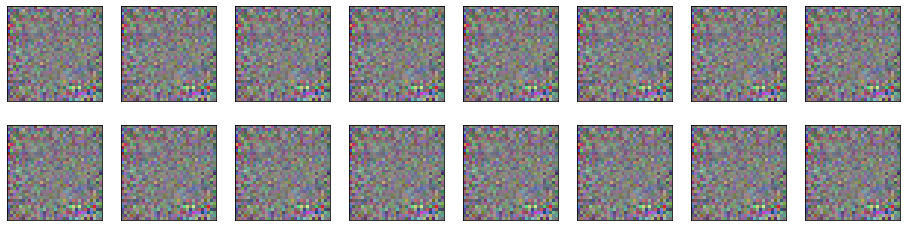

In [48]:
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.utils as vutils

In [ ]:
fig = plt.figure(figsize=(16,16))
plt.axis("off")

img_list = []

for img in samples:
    img_list.append(vutils.make_grid(img.detach(), padding=2, normalize=True))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
fig = plt.figure(figsize=(16,4))
plt.axis("off")

img_list = []

for img in samples:
    img_list.append(vutils.make_grid(img[47:52].detach(), padding=2, normalize=True))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())